## Observations and Insights 

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
mouse_results_df = pd.merge(mouse_metadata, study_results, on='Mouse ID')

# Display the data table for preview
mouse_results_df.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [2]:
# Checking the number of mice.
dup_records = mouse_results_df[mouse_results_df.duplicated(['Mouse ID','Timepoint'])]
dup_records

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
909,g989,Propriva,Female,21,26,0,45.000000,0
911,g989,Propriva,Female,21,26,5,47.570392,0
913,g989,Propriva,Female,21,26,10,49.880528,0
915,g989,Propriva,Female,21,26,15,53.442020,0
917,g989,Propriva,Female,21,26,20,54.657650,1


In [3]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
dup_record = dup_records['Mouse ID'].unique()
dup_record[0]

'g989'

In [4]:
# Optional: Get all the data for the duplicate mouse ID. 
mouse_results_df[mouse_results_df['Mouse ID']==dup_record[0]]

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0
913,g989,Propriva,Female,21,26,10,49.880528,0
914,g989,Propriva,Female,21,26,15,51.325852,1
915,g989,Propriva,Female,21,26,15,53.442020,0
916,g989,Propriva,Female,21,26,20,55.326122,1
917,g989,Propriva,Female,21,26,20,54.657650,1


In [5]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
clean_mouse_results_df = mouse_results_df.drop(mouse_results_df[mouse_results_df['Mouse ID']==dup_record[0]].index)
clean_mouse_results_df

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [6]:
# Checking the number of mice in the clean DataFrame.
len(clean_mouse_results_df['Mouse ID'].unique())

248

## Summary Statistics

In [7]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
drugregimen_df = clean_mouse_results_df.groupby('Drug Regimen')

mean_df = drugregimen_df['Tumor Volume (mm3)'].mean()
median_df = drugregimen_df['Tumor Volume (mm3)'].median()
var_df = drugregimen_df['Tumor Volume (mm3)'].var()
std_df = drugregimen_df['Tumor Volume (mm3)'].std()
sem_df = drugregimen_df['Tumor Volume (mm3)'].sem()

# Assemble the resulting series into a single summary dataframe.
summary_drugregimen_df = pd.DataFrame({'Tumor Volume Mean':mean_df
                                      ,'Tumor Volume Median':median_df
                                      ,'Tumor Volume Variance':var_df
                                      ,'Tumor Volume Standard Deviation':std_df
                                      ,'Tumor Volume SEM':sem_df
                                      })
summary_drugregimen_df

,Tumor Volume Mean,Tumor Volume Median,Tumor Volume Variance,Tumor Volume Standard Deviation,Tumor Volume SEM
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [8]:
# Using the aggregation method, produce the same summary statistics in a single line
summary_df = pd.DataFrame({'Tumor Volume Mean':[clean_mouse_results_df['Tumor Volume (mm3)'].mean()]
                          ,'Tumor Volume Median':[clean_mouse_results_df['Tumor Volume (mm3)'].median()]
                          ,'Tumor Volume Variance':[clean_mouse_results_df['Tumor Volume (mm3)'].var()]
                          ,'Tumor Volume Standard Deviation':[clean_mouse_results_df['Tumor Volume (mm3)'].std()]
                          ,'Tumor Volume SEM':[clean_mouse_results_df['Tumor Volume (mm3)'].sem()]
                          })
summary_df

,Tumor Volume Mean,Tumor Volume Median,Tumor Volume Variance,Tumor Volume Standard Deviation,Tumor Volume SEM
0,50.435293,48.933454,79.462907,8.914197,0.205591


## Bar and Pie Charts

Text(0, 0.5, 'Number of Measurements Taken')

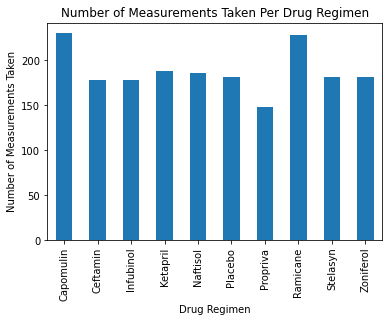

In [9]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pandas.
regimen_df = drugregimen_df['Drug Regimen'].count()
bar_plot = regimen_df.plot.bar(x='Drug Regimen', y='values', align='center', title='Number of Measurements Taken Per Drug Regimen')
bar_plot.set_ylabel('Number of Measurements Taken')

<BarContainer object of 10 artists>

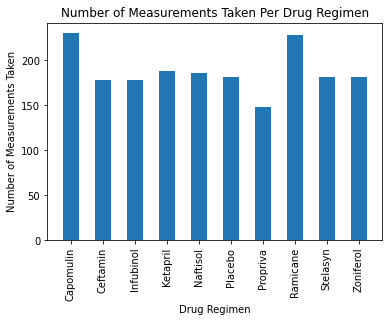

In [10]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pyplot.

# Create lists for the x & y values
count_df = drugregimen_df['Drug Regimen'].count()
regimen_ls = list(count_df.keys())
counts_ls = list(count_df.values.flatten())

# Configure x axis tickes
x_axis = np.arange(len(regimen_ls))
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, regimen_ls, rotation=90)

# Specify title & axis labels
plt.title('Number of Measurements Taken Per Drug Regimen')
plt.xlabel('Drug Regimen')
plt.ylabel('Number of Measurements Taken')

# plt.xlim(-.25,-.25)
# Plot chart
plt.bar(x_axis, counts_ls, align='center', width=.5)

Text(0, 0.5, 'Number of Mice')

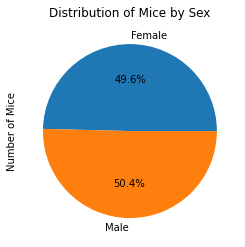

In [11]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
sex_df = clean_mouse_results_df.groupby('Sex')['Mouse ID'].nunique()
pie_plot = sex_df.plot.pie(y='values', title='Distribution of Mice by Sex', autopct="%1.1f%%")
pie_plot.set_ylabel('Number of Mice')

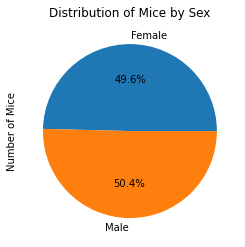

In [12]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
plt.title('Distribution of Mice by Sex')
plt.ylabel('Number of Mice')
labels = list(sex_df.keys())
plt.pie(sex_df, labels=labels, autopct="%1.1f%%")
plt.show()

## Quartiles, Outliers and Boxplots

In [13]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse
last_timepoint = clean_mouse_results_df.groupby('Mouse ID')['Timepoint'].max()

# Merge this group df with the original dataframe to get the tumor volume at the last timepoint
last_timepoint_df = clean_mouse_results_df.merge(last_timepoint, on='Mouse ID', suffixes=('','_max'))
last_timepoint_df = last_timepoint_df[last_timepoint_df['Timepoint']==last_timepoint_df['Timepoint_max']]
last_timepoint_df

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Timepoint_max
9,k403,Ramicane,Male,21,16,45,22.050126,1,45
19,s185,Capomulin,Female,3,17,45,23.343598,1,45
29,x401,Capomulin,Female,16,15,45,28.484033,0,45
39,m601,Capomulin,Male,22,17,45,28.430964,1,45
49,g791,Ramicane,Male,11,16,45,29.128472,1,45
...,...,...,...,...,...,...,...,...,...
1846,z314,Stelasyn,Female,21,28,5,45.934712,0,5
1849,z435,Propriva,Female,12,26,10,48.710661,0,10
1859,z581,Infubinol,Female,24,25,45,62.754451,3,45
1869,z795,Naftisol,Female,13,29,45,65.741070,3,45


In [14]:
# Put treatments into a list for for loop (and later for plot labels)
regimen_ls = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']

# Create empty list to fill with tumor vol data (for plotting)
tumor_val_ls = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
for regimen in regimen_ls:
    # Locate the rows which contain mice on each drug and get the tumor volumes
    temp_df = last_timepoint_df[last_timepoint_df['Drug Regimen']==regimen]
    
    # add subset
    values = temp_df['Tumor Volume (mm3)'] 
    tumor_val_ls.append(values)

    # Determine outliers using upper and lower bounds
    quartiles = temp_df['Tumor Volume (mm3)'].quantile([.25,.5,.75])
    lower = quartiles[.25]
    median = quartiles[.5]
    upper = quartiles[.75]
    iqr = upper-lower
    lower_bound = lower - (1.5 * iqr)
    upper_bound = upper + (1.5 * iqr)
    outliers_df = values.loc[(temp_df['Tumor Volume (mm3)'] <= lower_bound) |
                             (temp_df['Tumor Volume (mm3)'] >= upper_bound)]
    outliers_ct = len(outliers_df)
    output =  f'{regimen}:\n '
    output += f'Lower Quartile = {lower}\n Median = {median}\n Upper Quartile = {upper}\n '
    output += f'Interquartile Range = {iqr}\n Lower Outlier Boundary = {lower_bound}\n Upper Outlier Boundary = {upper_bound}\n '
    output += f'Outlier Count = {outliers_ct}\n'
    print(output)

Capomulin:
 Lower Quartile = 32.37735684
 Median = 38.125164399999996
 Upper Quartile = 40.1592203
 Interquartile Range = 7.781863460000004
 Lower Outlier Boundary = 20.70456164999999
 Upper Outlier Boundary = 51.83201549
 Outlier Count = 0

Ramicane:
 Lower Quartile = 31.56046955
 Median = 36.56165229
 Upper Quartile = 40.65900627
 Interquartile Range = 9.098536719999998
 Lower Outlier Boundary = 17.912664470000003
 Upper Outlier Boundary = 54.30681135
 Outlier Count = 0

Infubinol:
 Lower Quartile = 54.04860769
 Median = 60.16518046
 Upper Quartile = 65.52574285
 Interquartile Range = 11.477135160000003
 Lower Outlier Boundary = 36.83290494999999
 Upper Outlier Boundary = 82.74144559000001
 Outlier Count = 1

Ceftamin:
 Lower Quartile = 48.72207785
 Median = 59.85195552
 Upper Quartile = 64.29983003
 Interquartile Range = 15.577752179999997
 Lower Outlier Boundary = 25.355449580000002
 Upper Outlier Boundary = 87.66645829999999
 Outlier Count = 0



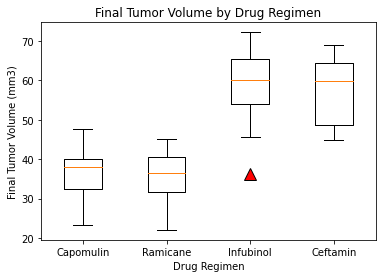

In [15]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest

# Specify outlier color, size & shape
flierprops = {'markerfacecolor':'red', 'markersize':12, 'marker':'^'}

# Create plot
plt.subplots()
plt.boxplot(tumor_val_ls, labels=regimen_ls, flierprops=flierprops)

# Specify title & axis labels
plt.title('Final Tumor Volume by Drug Regimen')
plt.ylabel('Final Tumor Volume (mm3)')
plt.xlabel('Drug Regimen')

#Show plot
plt.show()

## Line and Scatter Plots

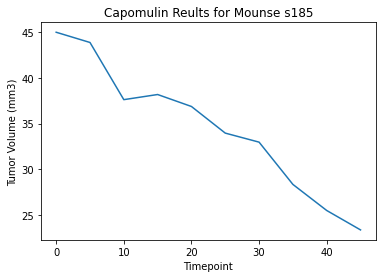

In [16]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin
mouse_df = clean_mouse_results_df[clean_mouse_results_df['Mouse ID']=='s185']

x_axis = mouse_df['Timepoint']
values = mouse_df['Tumor Volume (mm3)']

plt.plot(x_axis, values)
plt.xlabel('Timepoint')
plt.ylabel('Tumor Volume (mm3)')
plt.title('Capomulin Reults for Mounse s185')

plt.show()

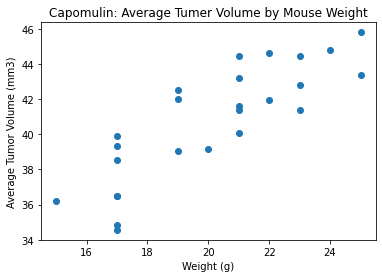

In [17]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen
Capomulin_df = clean_mouse_results_df[clean_mouse_results_df['Drug Regimen']=='Capomulin'].groupby('Mouse ID')
weight_df = Capomulin_df.mean()
weight_df = weight_df[['Weight (g)','Tumor Volume (mm3)']]

# min_weight = weight_df['Weight (g)'].min()
# max_weight = weight_df['Weight (g)'].max()

weight = weight_df['Weight (g)']
tumor_val = weight_df['Tumor Volume (mm3)']

plt.title('Capomulin: Average Tumer Volume by Mouse Weight')
plt.xlabel('Weight (g)')
plt.ylabel('Average Tumor Volume (mm3)')

plt.scatter(weight, tumor_val)
plt.show()

## Correlation and Regression

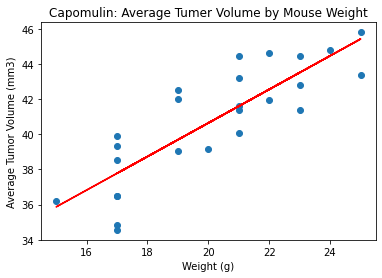

In [18]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(weight, tumor_val)
regress = weight * slope + intercept

plt.title('Capomulin: Average Tumer Volume by Mouse Weight')
plt.xlabel('Weight (g)')
plt.ylabel('Average Tumor Volume (mm3)')

plt.scatter(weight, tumor_val)
plt.plot(weight, regress, 'red')
plt.show()